## Imports

In [104]:
import itertools
import math
import shap

from collections import Counter

from eli5 import show_weights

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from pprint import *

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier,XGBRegressor
import xgboost as xgb
import lightgbm as lgb

import nltk
from collections import Counter
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/devillish_red/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Import Nike Data

In [2]:
nike = pd.read_csv("data/nike.csv", index_col = 0)

print("Basic information about our Nike.com dataset:\n")
print(nike.info())
print(
    "\n\nA little more summary info about our data "
    "(there\nare only a few columns in our data, making "
    "this\neasy to inspect):\n\n",
    nike.describe(),
)
print("\n\nAnd, the first few rows of our data:")
display(nike.head(3))

Basic information about our Nike.com dataset:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1368 entries, 0 to 1367
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   label          409 non-null    object 
 1   title          1368 non-null   object 
 2   subtitle       1367 non-null   object 
 3   num_colors     1368 non-null   object 
 4   price          1366 non-null   object 
 5   reduced_price  579 non-null    object 
 6   url            1368 non-null   object 
 7   description    1340 non-null   object 
 8   colors         840 non-null    object 
 9   n_reviews      1271 non-null   float64
 10  avg_stars      1271 non-null   float64
dtypes: float64(2), object(9)
memory usage: 128.2+ KB
None


A little more summary info about our data (there
are only a few columns in our data, making this
easy to inspect):

          n_reviews    avg_stars
count  1271.000000  1271.000000
mean     73.042486     3.432966


,label,title,subtitle,num_colors,price,reduced_price,url,description,colors,n_reviews,avg_stars
0,Best Seller,Air Jordan 1 Mid,Shoes,2 Colors,$125,NaN,https://www.nike.com/t/air-jordan-1-mid-shoes-...,"Inspired by the original AJ1, the Air Jordan 1...",Black/White/Fire Red; Black/Black/Black,2161.0,4.9
1,Best Seller,Nike Blazer Mid '77 Vintage,Women's Shoes,3 Colors,$105,NaN,https://www.nike.com/t/blazer-mid-77-vintage-w...,Styled for the ‘70s. Loved in the ‘80s. Classi...,White/White/Peach/White; White/Sail/Peach/Blac...,519.0,4.8
2,Coming Soon,Nike Dunk Low Retro,Men's Shoes,1 Color,$110,NaN,https://www.nike.com/t/dunk-low-retro-mens-sho...,Created for the hardwood but taken to the stre...,NaN,NaN,NaN


**Change `price` and `num_colors` to numeric**

In [3]:
nike['price'] = nike['price'].str.replace('$','').astype(np.float64)
nike['num_colors'] = nike['num_colors'].str.replace(' Colors','').str.replace(' Color','').astype(np.float64)

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


**Filling missing entries for `n_reviews` and `avg_stars` with zeros**

In [4]:
nike['n_reviews'].fillna(0, inplace = True)
nike['avg_stars'].fillna(0, inplace = True)

**Drop gift card items**

In [5]:
nike = nike[~nike['title'].str.contains("gift card", na = False, case = False)]

**Fill na for label with empty string**

In [6]:
nike['label'].fillna('', inplace=True)

**Count missing entries for each feature**

In [7]:
nike.isna().sum()

label              0
title              0
subtitle           0
num_colors         0
price              0
reduced_price    787
url                0
description       28
colors           528
n_reviews          0
avg_stars          0
dtype: int64

## Preprocess `subtitle` feature

In [8]:
pprint(list(nike.subtitle.unique())[100: 120])

["Little Kids' Easy On/Off Shoes",
 'Artificial-Turf Soccer Shoes',
 'Basketball Shoe',
 "Men's Trail Running Shoes",
 'Baby/Toddler Shoe',
 "Little/Big Kids' Road Running Shoes",
 "Women's Easy On/Off Road Running Shoes",
 'Custom Firm Ground Soccer Cleat',
 "Big Kids' Boots",
 "Little/Big Kids' Turf Soccer Shoes",
 "Men's Duckboot",
 'Men’s Training Shoes',
 'Custom Shoes',
 "Little Kids' Shoe ",
 "Women's Road Racing Shoes",
 'Indoor/Court Soccer Shoes',
 'Baseball Cleat',
 "Little/Big Kids' Cleats",
 "Women's Custom Shoes",
 "Women's HIIT Class Shoes"]


In [9]:
nike.loc[nike['subtitle'].str.contains("Men's", na = False, case = True), 'category'] = "Men's"
nike.loc[nike['subtitle'].str.contains("Women's", na = False, case = True), 'category'] = "Women's"
nike.loc[nike['subtitle'].str.contains("Kids", na = False, regex = True), 'category'] = "Kids"
nike.loc[nike['subtitle'].str.contains("toddler", na = False, case = False), 'category'] = "Infant's"
nike['category'].fillna("Men's", inplace = True) 

categories = nike['category'].value_counts(normalize = True)
categories

Men's       0.475842
Kids        0.247438
Women's     0.193997
Infant's    0.082723
Name: category, dtype: float64

In [10]:
nike['purpose'] = nike['subtitle']
nike = nike.replace({'purpose' : {".*Easy On/Off.*": "Lifestyle",
                                   ".*Custom.*" : "Custom",
                                   ".*Cleats.*": "Soccer",
                                   ".*style.*" : "Lifestyle",
                                   ".*Running.*" : "Running",
                                   ".*Basketball.*" : "Basketball",
                                   ".*Baseball.*" : "Baseball",
                                   ".*Indoor Court.*": "Training",
                                   ".*Endurance Class.*": "Training",
                                   ".*Volleyball.*" : "Volleyball",
                                   ".*HIIT.*" : "Training",
                                   ".*Skate.*" : "Skate",
                                   ".*Football.*" : "Football",
                                   ".*Boot.*" : "Boot",
                                   ".*Duckboot.*": "Boot",
                                   ".*Cycling.*" : "Cycling",
                                   ".*Sandal.*" : "Sandal",
                                   ".*Slide.*" : "Sandal",
                                   ".*Slip$" : "Sandal",
                                   ".*Slipper.*": "Sandal",
                                   ".*Mule.*": "Sandal",
                                   ".*Softball.*" : "Softball",
                                   ".*Golf.*" : "Golf",
                                   ".*Soccer.*" : "Soccer",
                                   ".*Tennis.*" : "Tennis",
                                   ".*Training.*" : "Training",
                                   ".*Weightlifting.*": "Weightlifting",
                                   ".*Racing.*" : "Racing",
                                   ".*Track.*" : "Track",
                                   ".*One Star.*": "Lifestyle"   
                                  }}, regex = True)
nike = nike.replace({'purpose' : {"Shoe[s]{0,1}": "Lifestyle",
                                  "Women's Shoe[s]{0,1}": "Lifestyle",
                                  "Men's Shoe[s]{0,1}": "Lifestyle",
                                  ".*Kids' Shoe[s]{0,1}": "Lifestyle"
                                  }}, regex = True)
nike.loc[nike['purpose'].str.contains("Lifestyle", na = False, case = True), 'purpose'] = "Lifestyle"

In [11]:
unique_cat = list(nike['category'].unique())
unique_purpose = list(nike['purpose'].unique())

print(f"There are {len(unique_cat)} unique categories and {len(unique_purpose)} unique purposes")
print(unique_cat)
pprint(nike['purpose'].value_counts())

There are 4 unique categories and 19 unique purposes
["Men's", "Women's", 'Kids', "Infant's"]
Lifestyle        782
Running          116
Soccer           106
Basketball        62
Sandal            61
Custom            50
Training          43
Boot              38
Golf              25
Skate             24
Track             19
Tennis            14
Baseball           9
Racing             7
Cycling            4
Football           2
Softball           2
Weightlifting      1
Volleyball         1
Name: purpose, dtype: int64


# EDA

## Plot Numeric Variables

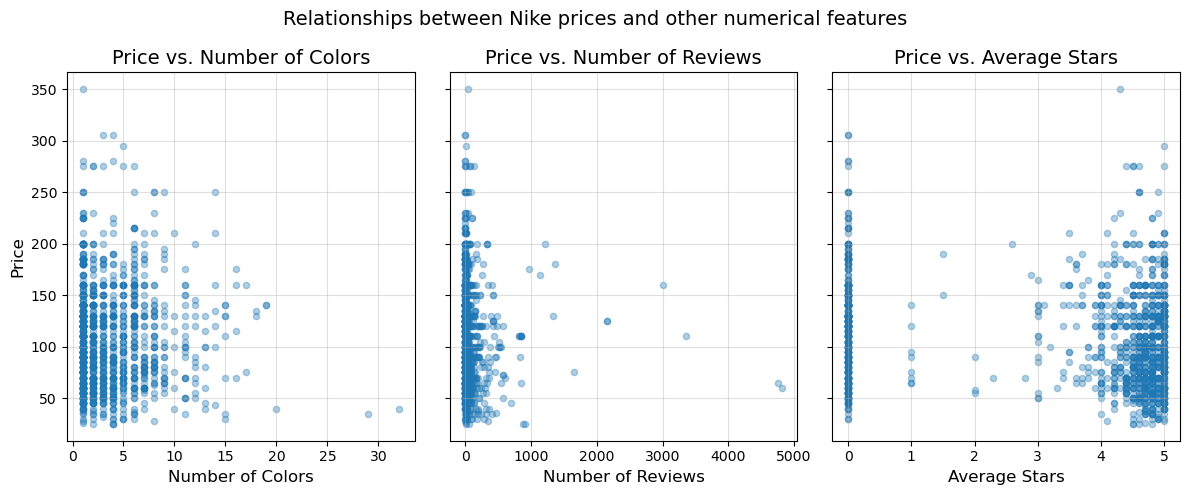

In [12]:
fig, axes = plt.subplots(1, 3, sharey = True, figsize = (12, 5))

fontsize = 14

cols = ["num_colors", "n_reviews", "avg_stars"] 
title_vs_text = ["num_colors", "n_reviews", "avg_stars"]
xlabels = ["Number of Colors", "Number of Reviews", "Average Stars"]

for i, (ax, col, title_vs, xlabel) in enumerate(
    zip(axes, cols, title_vs_text, xlabels)):

    ax.scatter(nike[col], nike["price"], alpha = 0.35, s = 20)
    ax.set_title(f"Price vs. {xlabel}", fontsize = fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize-2)
    ax.set_ylabel("Price" if i==0 else None, fontsize = fontsize - 2)
    ax.grid(":", alpha = 0.4)

plt.suptitle("Relationships between Nike prices and other numerical features", 
             fontsize = fontsize)
plt.tight_layout()

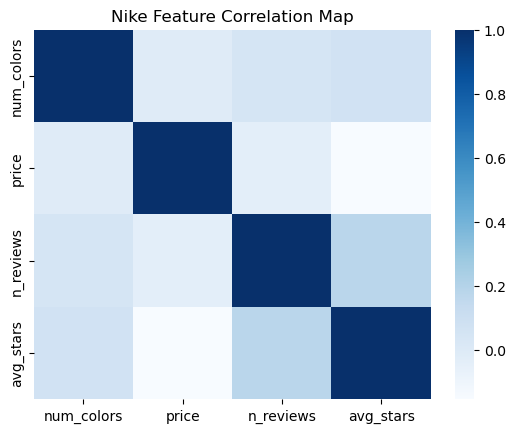

In [13]:
cor = nike.corr()

sns.heatmap(cor, cmap = 'Blues')
plt.title("Nike Feature Correlation Map")
plt.show()

## Plot Categorical Variables

In [14]:
list_label = nike['label'].unique().tolist()
len_label = len(list_label)
print(f'There are {len_label} unique labels which are {list_label}')

There are 10 unique labels which are ['Best Seller', 'Coming Soon', '', 'Sustainable Materials', 'Member Access', 'Customize', 'Just In', 'Launching in SNKRS', 'Available in SNKRS', 'Sold Out']


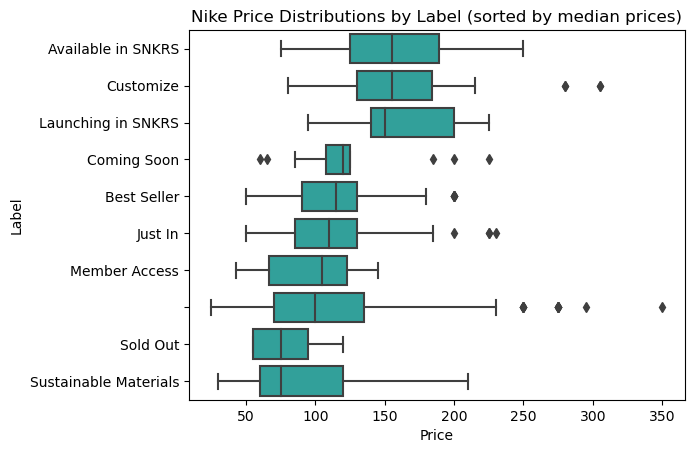

In [15]:
labels_sorted = nike.groupby('label').price.median().sort_values(ascending=False)

# order box plot by median
sns.boxplot(data = nike, y = 'label', x = 'price', 
            color = 'lightseagreen', order = labels_sorted.index)
plt.xlabel('Price')
plt.ylabel('Label')
plt.title('Nike Price Distributions by Label (sorted by median prices)')
plt.show()

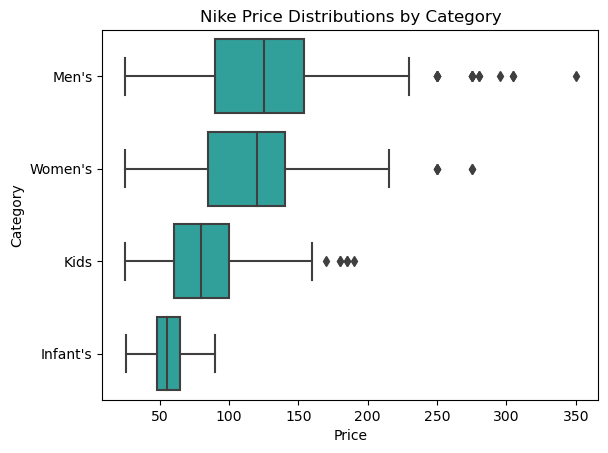

In [16]:
median_price_cat_sorted = nike.groupby('category').price.median().sort_values(ascending=False)

# order box plot by median
sns.boxplot(data = nike, y = 'category', x = 'price', 
            color = 'lightseagreen', order = median_price_cat_sorted.index)
plt.xlabel('Price')
plt.ylabel('Category')
plt.title('Nike Price Distributions by Category')
plt.show()

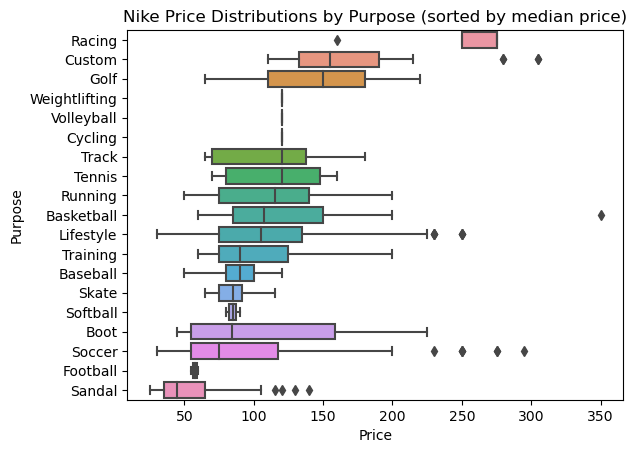

In [17]:
median_price_purpose_sorted = nike.groupby('purpose')['price'].median().sort_values(ascending = False)

# order box plot by median
sns.boxplot(data = nike, y = 'purpose', x = 'price', 
            order = median_price_purpose_sorted.index)
plt.xlabel('Price')
plt.ylabel('Purpose')
plt.title('Nike Price Distributions by Purpose (sorted by median price)')
plt.show()

## Numeric Stats

In [18]:
mean_price = nike["price"].mean() 
mean_noc = nike["num_colors"].mean()
std_price = nike["price"].std() 
std_noc = nike["num_colors"].std()
print(
    "\n"
    f"The mean price is {mean_price:.4f} \n"
    f"The mean number of colors is {mean_noc:.4f} \n"
    f"The Standard Deviation of price is {std_price:.4f}\n"
    f"The Standard Deviation of number of colors is {std_noc:.4f}"
)


The mean price is 108.3433 
The mean number of colors is 3.5271 
The Standard Deviation of price is 47.8272
The Standard Deviation of number of colors is 3.3761


In [19]:
price_min = nike["price"].min()
price_max = nike["price"].max() 
price_range = price_max - price_min 

print(
    f"The range of price for which shoes in our dataset "
    f"is {price_range:,.2f} dolloars. \n\n"
    f"The maximum number of price is {price_max:,.2f}, "
    f"and the minimum is {price_min:,.2f}."
)

The range of price for which shoes in our dataset is 325.00 dolloars. 

The maximum number of price is 350.00, and the minimum is 25.00.


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


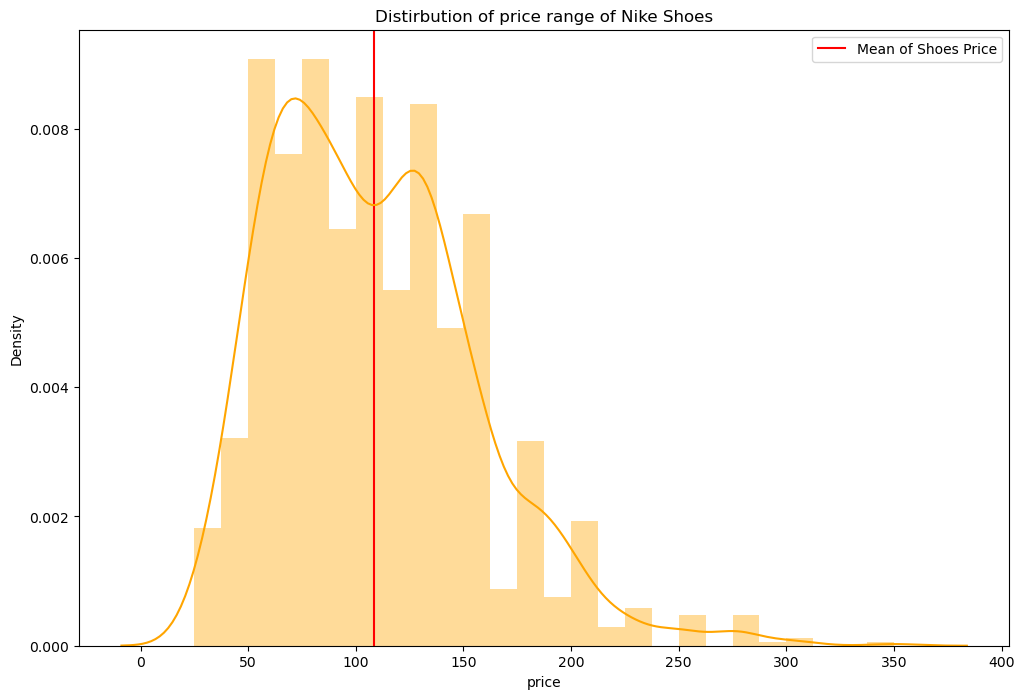

In [20]:
plt.figure(figsize=(12,8))
#ploting the mean
plt.axvline(mean_price, 0, 1, color = 'red', label='Mean of Shoes Price')
sns.distplot(nike['price'], color='orange')
plt.title("Distirbution of price range of Nike Shoes")
plt.legend()
plt.show()

<Figure size 500x300 with 0 Axes>

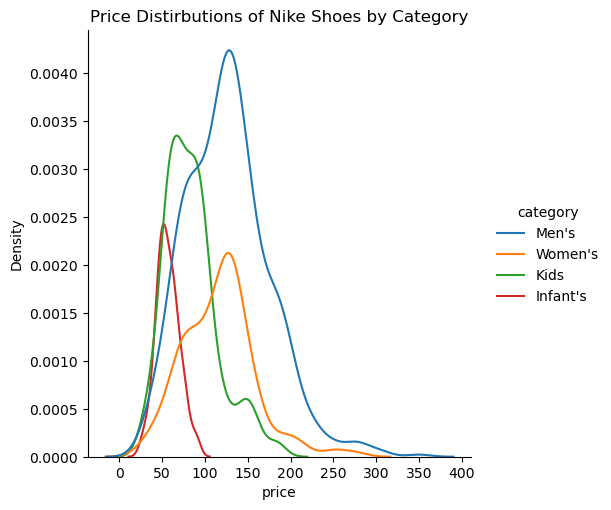

In [21]:
plt.figure(figsize=(5,3))
sns.displot(data = nike, x = "price", hue = "category", kind = "kde")
plt.title("Price Distirbutions of Nike Shoes by Category")
plt.show()

In [22]:
# copy nike df to work on
df = nike.loc[:, ['description','subtitle', 'price']].copy()
df.dropna(inplace = True)

In [23]:
analyzer = SIA()
# using sentiment analysis and get negative, neutral, poisitve scores on columns "rating"
df['rating'] = df['description'].apply(analyzer.polarity_scores)
df.head()

,description,subtitle,price,rating
0,"Inspired by the original AJ1, the Air Jordan 1...",Shoes,125.0,"{'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'comp..."
1,Styled for the ‘70s. Loved in the ‘80s. Classi...,Women's Shoes,105.0,"{'neg': 0.014, 'neu': 0.722, 'pos': 0.264, 'co..."
2,Created for the hardwood but taken to the stre...,Men's Shoes,110.0,"{'neg': 0.039, 'neu': 0.682, 'pos': 0.279, 'co..."
3,The radiance lives on in the Nike Air Force 1 ...,Men's Shoes,110.0,"{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp..."
4,No need to call for a ride—MJ's game-winning l...,Men's Shoes,200.0,"{'neg': 0.031, 'neu': 0.832, 'pos': 0.137, 'co..."


In [24]:
# change each keys/values of dictionary in column rating, to be the new columns of dataframe
df_sentiment = pd.concat([df.drop(['rating'], axis=1), df['rating'].apply(pd.Series)], axis=1)
df_sentiment.head()

,description,subtitle,price,neg,neu,pos,compound
0,"Inspired by the original AJ1, the Air Jordan 1...",Shoes,125.0,0.000,0.658,0.342,0.8885
1,Styled for the ‘70s. Loved in the ‘80s. Classi...,Women's Shoes,105.0,0.014,0.722,0.264,0.9726
2,Created for the hardwood but taken to the stre...,Men's Shoes,110.0,0.039,0.682,0.279,0.9446
3,The radiance lives on in the Nike Air Force 1 ...,Men's Shoes,110.0,0.000,0.671,0.329,0.9349
4,No need to call for a ride—MJ's game-winning l...,Men's Shoes,200.0,0.031,0.832,0.137,0.8176


In [25]:
df_sentiment['score'] = np.where(df_sentiment['compound'] < 0, 'negative', 'positive')
df_sentiment.head()

,description,subtitle,price,neg,neu,pos,compound,score
0,"Inspired by the original AJ1, the Air Jordan 1...",Shoes,125.0,0.000,0.658,0.342,0.8885,positive
1,Styled for the ‘70s. Loved in the ‘80s. Classi...,Women's Shoes,105.0,0.014,0.722,0.264,0.9726,positive
2,Created for the hardwood but taken to the stre...,Men's Shoes,110.0,0.039,0.682,0.279,0.9446,positive
3,The radiance lives on in the Nike Air Force 1 ...,Men's Shoes,110.0,0.000,0.671,0.329,0.9349,positive
4,No need to call for a ride—MJ's game-winning l...,Men's Shoes,200.0,0.031,0.832,0.137,0.8176,positive


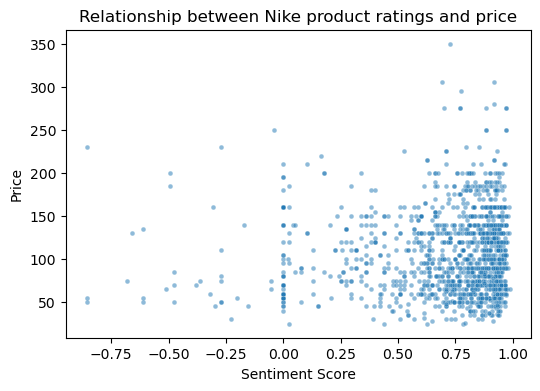

In [26]:
plt.figure(figsize = (6,4))
sns.scatterplot(data = df_sentiment, x = 'compound', y = "price",
                alpha = 0.5, s = 12) #hue = 'subtitle'
plt.xlabel("Sentiment Score")
plt.ylabel("Price")
plt.title("Relationship between Nike product ratings and price")
plt.show()

# NLP Analysis and Preprocessing

## Process Column `description` from Raw Text to Bag-of-Words

In [27]:
df = nike.loc[:, ['title', 'category', 'purpose', 'description', 'price']].copy()  # subset
df['text'] = df['title'].str.cat(df['category'], sep = '; ', na_rep = '')
df['text'] = df['text'].str.cat(df['purpose'], sep = '; ', na_rep = '')
df['text'] = df['text'].str.cat(df['description'], sep = '; ', na_rep = '')

df = df[['text', 'price']]
df.head()

,text,price
0,Air Jordan 1 Mid; Men's; Lifestyle; Inspired b...,125.0
1,Nike Blazer Mid '77 Vintage; Women's; Lifestyl...,105.0
2,Nike Dunk Low Retro; Men's; Lifestyle; Created...,110.0
3,Nike Air Force 1 '07; Men's; Lifestyle; The ra...,110.0
4,Air Jordan 12 Retro; Men's; Lifestyle; No need...,200.0


In [28]:
# to lower
df['text'] = df['text'].str.lower()
# remove punctuation
df['text'] = df['text'].str.replace(r'([^\w\s]|_)+', '', regex=True)
# tokenization
df['text'] = df['text'].str.split()
# load list of stop words
stopwords = pd.read_csv('data/stopwords_nopunc.csv').stopwords.values
# remove stop words from data
df['text'] = df['text'].apply(lambda x: [str(w) for w in x if w not in stopwords])
# create a dictionary (or Series) with the counts of each unique vocab word
vocab_counts = df['text'].explode().value_counts()

In [29]:
# define vocabulary
# list of unique words occuring at least 5 times in the dataset
min_count = 5
vocab = [k for k,v in vocab_counts.items() if v >= 5]

In [30]:
print(f"We have {len(vocab):,} unique words in our reduced, corpus vocabulary.")

We have 1,514 unique words in our reduced, corpus vocabulary.


In [31]:
# remove low-occurance words
# vectorization methods
df['text'] = df['text'].apply(lambda x: [w for w in x if w in vocab])
# bag of words representation
# list of Counters
# each Counter containing word counts for each row in the DataFrame
counts = df['text'].apply(Counter).to_list()
# Create bag-of-words df from list of dictionaries
bow_df = pd.DataFrame(counts).fillna(0).astype(int)
bow_df.head(2)

,air,jordan,1,mid,mens,lifestyle,inspired,original,aj1,offers,...,grass,artisan,coating,slides,decades,internationalist,eyestays,pink,ispa,guo
0,2,2,2,2,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Make `price` Categorical with Binning

In [32]:
# df.reset_index(drop=True, inplace=True)
# combine what is effectively our X and y into a single DataFrame
# df_processed = bow_df.join(df[['price']])
df_processed = pd.concat([bow_df, df['price']], axis=1)
df_processed.head()

,air,jordan,1,mid,mens,lifestyle,inspired,original,aj1,offers,...,artisan,coating,slides,decades,internationalist,eyestays,pink,ispa,guo,price
0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.0
1,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0
3,2.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0
4,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0


In [33]:
# check default percentile cut
pd.cut(df_processed.price, bins = 5).value_counts()

(24.675, 90.0]    595
(90.0, 155.0]     568
(155.0, 220.0]    173
(220.0, 285.0]     26
(285.0, 350.0]      4
Name: price, dtype: int64

The above cuts are extremely imbalanced. Manual cuts are performed based on the discretion

In [34]:
# make everything > 200 its only bin
df_processed['is_above_180'] = df_processed.price > 180
df_processed['bracket'] = df_processed.price > 180
df_processed['bracket'].replace(True, 'above_180', inplace=True)
df_processed['bracket'].replace(False, np.nan, inplace=True)

In [35]:
# use default binning for <= 200
binned_low_brackets = pd.cut(df_processed.loc[~df_processed['is_above_180'], 'price'], 
                             bins = 4)
# combine the bins
df_processed['bracket'] = df_processed['bracket'].fillna(binned_low_brackets)
df_processed['price'] = df_processed['bracket']  # .astype('string')
print("Price brackets:")
print(df_processed['price'].value_counts())
print(df_processed['price'].value_counts(normalize = True))

Price brackets:
(63.75, 102.5]     448
(102.5, 141.25]    401
(24.845, 63.75]    245
(141.25, 180.0]    167
above_180          105
Name: price, dtype: int64
(63.75, 102.5]     0.327965
(102.5, 141.25]    0.293558
(24.845, 63.75]    0.179356
(141.25, 180.0]    0.122255
above_180          0.076867
Name: price, dtype: float64


In [36]:
# clean up
df_processed.drop(['is_above_180', 'bracket'], axis = 1, inplace=True)
df_processed.head()

,air,jordan,1,mid,mens,lifestyle,inspired,original,aj1,offers,...,artisan,coating,slides,decades,internationalist,eyestays,pink,ispa,guo,price
0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(102.5, 141.25]"
1,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(102.5, 141.25]"
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(102.5, 141.25]"
3,2.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(102.5, 141.25]"
4,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,above_180


In [37]:
df_processed.dropna(inplace = True)

## Naive Bayes Model of `price ~ bag_of_words(description)`

In [38]:
df_processed1 = df_processed.copy()
df_processed1['price'] = df_processed1['price'].astype('string')

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_processed1.drop('price', axis = 1),
                                                    df_processed1['price'], 
                                                    test_size = 0.2, random_state = 2)

In [40]:
mnb = MultinomialNB(alpha = 0.001).fit(X_train, y_train)

In [41]:
mnb.score(X_test, y_test)

0.31135531135531136

***Feature importance for each class:***

In [42]:
# 5 brackets
y_train.value_counts(sort=False)

(63.75, 102.5]     357
(102.5, 141.25]    318
(24.845, 63.75]    202
(141.25, 180.0]    132
above_180           82
Name: price, dtype: Int64

In [43]:
# get most predictive words for each class (bracket 1 and bracket 3)
feat_imp_list = []

for i in range(len(mnb.classes_)):
    class_prob_sorted = mnb.feature_log_prob_[i, :].argsort()[::-1]
    top_pred_words = np.take(bow_df.columns, class_prob_sorted[:])
    feat_imp_list.append(top_pred_words)

**The top 10 most predictive words for each price bracket:**

In [44]:
# prettify list to df
feat_imp_df = pd.DataFrame(np.array(feat_imp_list).T, columns=mnb.classes_)
feat_imp_df = feat_imp_df.loc[:, y_train.value_counts(sort=False).index]  # reorder columns
feat_imp_df.head(10)

,"(63.75, 102.5]","(102.5, 141.25]","(24.845, 63.75]","(141.25, 180.0]",above_180
0,nike,nike,nike,nike,nike
1,air,air,air,air,air
2,lifestyle,lifestyle,lifestyle,lifestyle,lifestyle
3,mens,mens,mens,mens,mens
4,design,1,max,max,design
5,1,design,design,design,max
6,kids,max,kids,kids,kids
7,max,comfort,2,comfort,look
8,zoom,classic,cushioning,look,comfort
9,running,jordan,1,jordan,1


# Word Feature Importance with Random Forest

In [45]:
rf = RandomForestClassifier(n_estimators = 80, max_depth = 10,
                            min_samples_leaf = 8, random_state = 0).fit(X_train, y_train)
random_forest_train_score = rf.score(X_train, y_train)
random_forest_test_score = rf.score(X_test, y_test)

In [46]:
print(f"random forest training score is {random_forest_train_score}")
print(f"random forest test score is {random_forest_test_score}")

random forest training score is 0.4399633363886343
random forest test score is 0.3663003663003663


In [47]:
top_predictors_rf = df_processed.columns[[dtree.tree_.feature[0] for dtree in rf.estimators_]]
top_predictors_rf = pd.Series(top_predictors_rf).value_counts().sort_values(ascending = False)
top_predictors_rf = pd.DataFrame(top_predictors_rf, columns = ['Count'])
print("Top Predictor Counts - Random Forest")
display(top_predictors_rf)

Top Predictor Counts - Random Forest


,Count
legend,3
stitching,3
nike,2
lowtop,2
check,2
...,...
lightest,1
legacy,1
ankle,1
flair,1


In [48]:
def plot_feature_importance(importance, names, imp_type, selected_top = 10):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    
    plt.figure(figsize=(6,4))
    sns.barplot(x = fi_df.head(selected_top)['feature_importance'], 
                y = fi_df.head(selected_top)['feature_names'],
                color = 'lightseagreen')
    #Add chart labels
    plt.title(imp_type + 'Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    
# Helper function to plot the feature importance (MDI & Perm)
def plot_feature_importance_compare(mdi_imp, perm_imp, colnames):
    plt.xkcd(scale=0.3,randomness=0.6)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

    mdi_importance_sorted_idx = np.argsort(mdi_imp)
    mdi_indices = np.arange(0, len(mdi_imp)) +0.5

    ax1.barh(mdi_indices, result1.importances_mean[mdi_importance_sorted_idx], 
              height = 0.7, color = '#B2D7D0')
    ax1.set_yticks(mdi_indices)
    ax1.set_yticklabels(colnames[mdi_importance_sorted_idx], fontsize = 12)
    ax1.set_ylim((0, len(mdi_imp)))
    ax1.set_xlabel("MDI-Based Feature Importance", fontsize = 16)


    perm_importance_sorted_idx = np.argsort(perm_imp)
    perm_indices = np.arange(0, len(perm_imp)) +0.5
    # difference = perm_imp['importances_mean'] - perm_imp['importances_mean']
    # difference = difference[perm_importance_sorted_idx]

    ax2.barh(perm_indices, perm_imp[perm_importance_sorted_idx], 
              height = 0.7, color = '#EFAEA4')
   
    ax2.set_yticks(perm_indices)
    ax2.set_yticklabels(X.columns[perm_importance_sorted_idx], fontsize = 12)
    ax2.set_ylim((0, len(perm_imp)))
    ax2.set_xlabel("Permutation Feature Importance", fontsize = 16)
    maxlim = max(perm_imp)
    ax2.set_xlim(0, maxlim + 0.015)
    ax1.set_title("MDI-Based Importance", fontsize = 18)
    ax2.set_title("Permutation Importance", fontsize = 18)
    fig.tight_layout()
    plt.show()

**MDI-based and permutation feature importances**

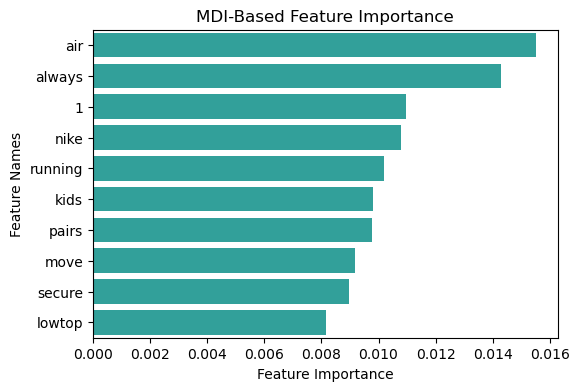

In [49]:
# TODO: X_train cols too big -> takes too long to compute
# perm_imp = permutation_importance(rf, X_train, y_train)['importances_mean']
# plot_feature_importance_compare(rf.feature_importances_, perm_imp, list(X_train.columns))
plot_feature_importance(rf.feature_importances_, X_train.columns, 'MDI-Based ')
# plot_feature_importance(permutation_importance(rf, X_train, y_train), X_train.columns, 'Permutation')

# TFIDF on BOW

***TF-IDF on text column - use this for modeling as an alternative to BOW***

In [50]:
# subset
df = nike.loc[:, ['title', 'category', 'purpose', 'description', 'price']].copy()  # subset
df['text'] = df['title'].str.cat(df['category'], sep = '; ', na_rep = '')
df['text'] = df['text'].str.cat(df['purpose'], sep = '; ', na_rep = '')
df['text'] = df['text'].str.cat(df['description'], sep = '; ', na_rep = '')

# to lower
df['text'] = df['text'].str.lower()
# remove punctuation
df['text'] = df['text'].str.replace(r'([^\w\s]|_)+', '', regex=True)
# tokenization
df['text'] = df['text'].str.split()
# load list of stop words
stopwords = pd.read_csv('data/stopwords_nopunc.csv').stopwords.values
# remove stop words from data
df['text'] = df['text'].apply(lambda x: [str(w) for w in x if w not in stopwords])

# join list to make text a string again
df['text'] = df['text'].apply(lambda x: " ".join(x))

# subset
df = df[['text', 'price']]
df.dropna(inplace = True)  # dropna

In [51]:
# make TF-IDF matrix
tfidf_vec = TfidfVectorizer(sublinear_tf = True, smooth_idf = True)
tfidf_mat = tfidf_vec.fit_transform(df['text'])
df_tfidf = pd.DataFrame(tfidf_mat.todense(), 
                        columns = tfidf_vec.get_feature_names_out())
display(df_tfidf.head())
df_tfidf.to_csv("data/nike_tfidf_mat.csv")

,00s,01,04,05,06,07,10,100,10000,10k,...,zion,zions,zip,zipper,zonal,zone,zoned,zones,zoom,zoomx
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.354813,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094763,0.0


In [52]:
df_tfidf.shape

(1366, 4833)

***Calculate each word's TF-IDF score relative to each of the 5 price brackets.***

***(This is for EDA)***

In [53]:
df_docs = df_processed.groupby('price').sum()
df_docs

,air,jordan,1,mid,mens,lifestyle,inspired,original,aj1,offers,...,grass,artisan,coating,slides,decades,internationalist,eyestays,pink,ispa,guo
price,,,,,,,,,,,,,,,,,,,,,
"(24.845, 63.75]",221.0,50.0,61.0,30.0,104.0,135.0,28.0,29.0,4.0,6.0,...,1.0,0.0,0.0,2.0,1.0,3.0,2.0,2.0,0.0,5.0
"(63.75, 102.5]",376.0,92.0,134.0,50.0,204.0,259.0,54.0,47.0,4.0,17.0,...,0.0,1.0,3.0,1.0,2.0,0.0,1.0,3.0,4.0,0.0
"(102.5, 141.25]",381.0,91.0,154.0,48.0,213.0,237.0,35.0,44.0,8.0,13.0,...,4.0,3.0,1.0,2.0,0.0,3.0,1.0,0.0,2.0,0.0
"(141.25, 180.0]",155.0,43.0,40.0,20.0,79.0,96.0,18.0,12.0,0.0,4.0,...,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0
above_180,119.0,28.0,27.0,10.0,51.0,59.0,7.0,11.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


***Transform BOW representation into list of documents:***

In [54]:
docs = []  # documents - a list of strings (unique words concatenated for each bracket)

for bracket in df_docs.index:
    row = df_docs.loc[bracket, :]
    # logic: replace nonzero with NA; fill NA with column names; remove unfilled values (counts)
    row[row != 0] = np.nan
    doc = row.astype('string').fillna(row.index.to_series())
    doc = doc.loc[~doc.str.match('.+\..+')].tolist()
    doc = ' '.join(doc)
    docs.append(doc)

# docs[4]  # concatenated unique words for last price bracket

***TF-IDF of each word relative to each price bracket***

In [55]:
corpus = docs
vectorizer = TfidfVectorizer(use_idf=True)
tfIdf = vectorizer.fit_transform(corpus)
df_tfidf_by_price = pd.DataFrame(tfIdf.T.todense(), 
                        index = vectorizer.get_feature_names_out(), 
                        columns = df_docs.index)

df_tfidf_by_price

price,"(24.845, 63.75]","(63.75, 102.5]","(102.5, 141.25]","(141.25, 180.0]",above_180
06,0.035038,0.031008,0.000000,0.037308,0.000000
07,0.024930,0.022062,0.022954,0.026545,0.029171
10,0.029475,0.026085,0.027139,0.000000,0.034489
100,0.000000,0.031008,0.032261,0.037308,0.000000
11,0.024930,0.022062,0.022954,0.026545,0.029171
...,...,...,...,...,...
young,0.035038,0.031008,0.000000,0.037308,0.000000
zion,0.035038,0.031008,0.032261,0.000000,0.000000
zone,0.024930,0.022062,0.022954,0.026545,0.029171
zoom,0.024930,0.022062,0.022954,0.026545,0.029171


***TF-IDF should give us some idea of words that are truly unique to each bracket:***

In [56]:
# check out first bracket's words with top 10 TF-IDF
df_tfidf_by_price.iloc[:, 0].sort_values(ascending = False).head(10)

guo         0.052319
ishod       0.042210
utility     0.042210
wair        0.042210
effort      0.042210
kidright    0.042210
gen         0.042210
lane        0.042210
burrow      0.042210
vapormax    0.042210
Name: (24.845, 63.75], dtype: float64

In [57]:
# check out first bracket's words with bottom 10 TF-IDF
df_tfidf_by_price.iloc[:, 0].sort_values(ascending = True).head(10)

quicker      0.0
matchwhen    0.0
towards      0.0
matters      0.0
mc           0.0
cupsole      0.0
shots        0.0
md           0.0
mean         0.0
shot         0.0
Name: (24.845, 63.75], dtype: float64

In [58]:
# check out last bracket's words with top 10 TF-IDF
df_tfidf_by_price.iloc[:, 4].sort_values(ascending = False).head(10)

describe      0.04939
notice        0.04939
tailwind      0.04939
towards       0.04939
pays          0.04939
king          0.04939
embroidery    0.04939
beginnings    0.04939
national      0.04939
vapormax      0.04939
Name: above_180, dtype: float64

In [59]:
# check out last bracket's words with bottom 10 TF-IDF
df_tfidf_by_price.iloc[:, 4].sort_values(ascending = True).head(10)

06         0.0
loved      0.0
lugs       0.0
lunar      0.0
magic      0.0
manoa      0.0
mc         0.0
mcs        0.0
mean       0.0
meaning    0.0
Name: above_180, dtype: float64

## Prep Data for Advanced Modeling

### Non text features

In [60]:
# drop NA based on col description
df = nike.dropna(subset = ['description']).copy()
df.head(1)

,label,title,subtitle,num_colors,price,reduced_price,url,description,colors,n_reviews,avg_stars,category,purpose
0,Best Seller,Air Jordan 1 Mid,Shoes,2.0,125.0,NaN,https://www.nike.com/t/air-jordan-1-mid-shoes-...,"Inspired by the original AJ1, the Air Jordan 1...",Black/White/Fire Red; Black/Black/Black,2161.0,4.9,Men's,Lifestyle


In [61]:
# subtitle categorical feature
purpose_freq = df.purpose.value_counts()
purpose_freq

Lifestyle        757
Running          116
Soccer           106
Basketball        62
Sandal            61
Custom            47
Training          43
Boot              38
Golf              25
Skate             24
Track             19
Tennis            14
Baseball           9
Racing             7
Cycling            4
Football           2
Softball           2
Weightlifting      1
Volleyball         1
Name: purpose, dtype: int64

In [62]:
# clean purpose up - counts < 30, make them into an 'other' purpose
df.loc[df.purpose.isin(purpose_freq[purpose_freq < 30].index), 'purpose'] = 'other'

### Other non text features

In [63]:
# subset
df_sub = df.loc[:, ['num_colors', 'n_reviews', 'avg_stars', 'category', 'purpose']].copy()
df_sub.head(3)

,num_colors,n_reviews,avg_stars,category,purpose
0,2.0,2161.0,4.9,Men's,Lifestyle
1,3.0,519.0,4.8,Women's,Lifestyle
2,1.0,0.0,0.0,Men's,Lifestyle


In [64]:
# dummy
df_sub = pd.get_dummies(df_sub)
df_sub.head(3)

,num_colors,n_reviews,avg_stars,category_Infant's,category_Kids,category_Men's,category_Women's,purpose_Basketball,purpose_Boot,purpose_Custom,purpose_Lifestyle,purpose_Running,purpose_Sandal,purpose_Soccer,purpose_Training,purpose_other
0,2.0,2161.0,4.9,0,0,1,0,0,0,0,1,0,0,0,0,0
1,3.0,519.0,4.8,0,0,0,1,0,0,0,1,0,0,0,0,0
2,1.0,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [65]:
# prefix all non-text features - to distinguish from BOW words
df_sub.columns = ['feature_' + col for col in df_sub.columns]
df_sub.head(3)

,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_category_Infant's,feature_category_Kids,feature_category_Men's,feature_category_Women's,feature_purpose_Basketball,feature_purpose_Boot,feature_purpose_Custom,feature_purpose_Lifestyle,feature_purpose_Running,feature_purpose_Sandal,feature_purpose_Soccer,feature_purpose_Training,feature_purpose_other
0,2.0,2161.0,4.9,0,0,1,0,0,0,0,1,0,0,0,0,0
1,3.0,519.0,4.8,0,0,0,1,0,0,0,1,0,0,0,0,0
2,1.0,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0


**Perform Dimensionality on TF-IDF matric** before concatenating it with the original features

In [66]:
df_tfidf = pd.read_csv("data/nike_tfidf_mat.csv", index_col = 0)
df_tfidf.head(2)

,00s,01,04,05,06,07,10,100,10000,10k,...,zion,zions,zip,zipper,zonal,zone,zoned,zones,zoom,zoomx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# This will lose interpretability
# svd = TruncatedSVD(n_components = 100, n_iter = 10, random_state = 0)
# reduced_tfidf = svd.fit_transform(df_tfidf)
# reduced_tfidf

### Concatenate original features with BOW

In [68]:
df_model = df_processed[['price']].join(df_sub).join(df_tfidf)
# df_model = pd.concat([df_processed[['price']], df_sub, df_tfidf], axis = 1)
df_model.rename({'price': 'target_price'}, axis = 1, inplace = True)
display(df_model.head())
df_model.isna().sum()

,target_price,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_category_Infant's,feature_category_Kids,feature_category_Men's,feature_category_Women's,feature_purpose_Basketball,feature_purpose_Boot,...,zion,zions,zip,zipper,zonal,zone,zoned,zones,zoom,zoomx
0,"(102.5, 141.25]",2.0,2161.0,4.9,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,"(102.5, 141.25]",3.0,519.0,4.8,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,"(102.5, 141.25]",1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,"(102.5, 141.25]",2.0,128.0,4.9,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,above_180,1.0,333.0,4.9,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094763,0.0


target_price                  0
feature_num_colors           28
feature_n_reviews            28
feature_avg_stars            28
feature_category_Infant's    28
                             ..
zone                          0
zoned                         0
zones                         0
zoom                          0
zoomx                         0
Length: 4850, dtype: int64

### convert `target_price` into integer

In [69]:
# the original labels
df_model['target_price'].value_counts()

(63.75, 102.5]     447
(102.5, 141.25]    401
(24.845, 63.75]    245
(141.25, 180.0]    166
above_180          105
Name: target_price, dtype: int64

In [70]:
df_model['target_price'] = df_model['target_price'].astype('category')
labels = df_model['target_price'].cat.categories
labels = [str(x) for x in list(labels)]
labels

['(24.845, 63.75]',
 '(63.75, 102.5]',
 '(102.5, 141.25]',
 '(141.25, 180.0]',
 'above_180']

In [71]:
# label to int
df_model['target_price'] = df_model['target_price'].cat.codes
df_model['target_price'].value_counts()

1    447
2    401
0    245
3    166
4    105
Name: target_price, dtype: int64

Note the structure:

- target: `target_price`
- non-text features: `feature_xxx`
- text features from description: put at the end of the df

# Classification Model

## XGBoost Classification

In [72]:
est_df = df_model.loc[:,~df_model.columns.duplicated()]
X = est_df.drop('target_price', axis=1)
Y = est_df.iloc[:, 0].values

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = test_size, random_state = seed)

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)
Accuracy: 44.79%


In [73]:
print(classification_report(y_test, y_pred, target_names = labels))

                 precision    recall  f1-score   support

(24.845, 63.75]       0.71      0.55      0.62        85
 (63.75, 102.5]       0.45      0.53      0.49       144
(102.5, 141.25]       0.41      0.57      0.48       129
(141.25, 180.0]       0.14      0.05      0.08        56
      above_180       0.14      0.05      0.08        37

       accuracy                           0.45       451
      macro avg       0.37      0.35      0.35       451
   weighted avg       0.42      0.45      0.43       451



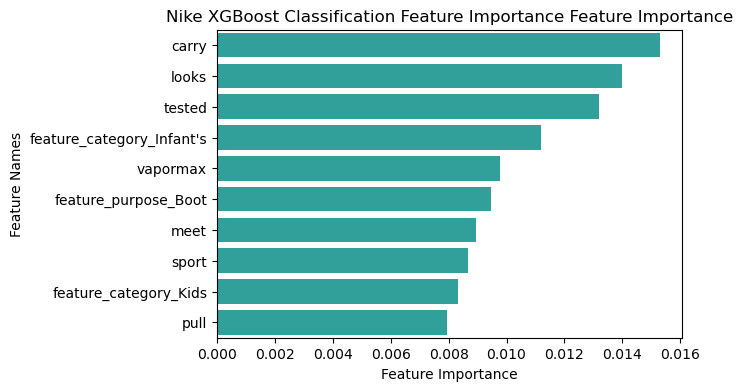

In [74]:
importances = model.feature_importances_
plot_feature_importance(importances, list(est_df.drop('target_price', axis = 1).columns), "Nike XGBoost Classification Feature Importance ")

In [75]:
features = list(X_train.columns)
importance = model.feature_importances_


In [76]:
# sorted_idx = model.feature_importances_.argsort()
# plt.barh(features[sorted_idx][-20:], importance[sorted_idx][-20:])
# plt.xlabel("MDI-Based Feature Importance")
# plt.ylabel("Feature Names")
# plt.title("Xgboost Feature Importance: Top 20 Features")

In [77]:
# TAKES VERY LONG

# perm_importance = permutation_importance(model,X_test,y_test)
# sorted_idx_perm = perm_importance.importances_mean.argsort()
# plt.barh(features[sorted_idx_perm][-20:],perm_importance[sorted_idx_perm][-20:])
# plt.xlabel("Xgboost Permutation Feature Importance: Top 20 Most Important Features")

## LGBM Classification

In [78]:
params = {'boosting': 'gbdt', 'objective': 'multiclass', 'num_leaves': 10, 'num_class': 5}
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference = lgb_train)

model = lgb.train(params, train_set = lgb_train, 
                  valid_sets = lgb_eval, early_stopping_rounds = 30)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6054
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 298
[LightGBM] [Info] Start training from score -1.741562
[LightGBM] [Info] Start training from score -1.103003
[LightGBM] [Info] Start training from score -1.210934
[LightGBM] [Info] Start training from score -2.116256
[LightGBM] [Info] Start training from score -2.597228
[1]	valid_0's multi_logloss: 1.43849
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.39113
[3]	valid_0's multi_logloss: 1.35538
[4]	valid_0's multi_logloss: 1.32711
[5]	valid_0's multi_logloss: 1.30866
[6]	valid_0's multi_logloss: 1.29241
[7]	valid_0's multi_logloss: 1.28188
[8]	valid_0's multi_logloss: 1.27426
[9]	valid_0's mult

In [79]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred,axis=1)

cr = classification_report(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)

print(cr)
pd.crosstab(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.73      0.62      0.67        85
           1       0.46      0.61      0.52       144
           2       0.44      0.56      0.49       129
           3       0.23      0.05      0.09        56
           4       0.29      0.05      0.09        37

    accuracy                           0.48       451
   macro avg       0.43      0.38      0.37       451
weighted avg       0.46      0.48      0.45       451



col_0,0,1,2,3,4
row_0,,,,,
0,53,28,4,0,0
1,13,88,41,1,1
2,1,46,72,8,2
3,3,17,31,3,2
4,3,14,17,1,2


<AxesSubplot:title={'center':"LBGM Classifier's Top 20 Features"}, xlabel='Feature importance', ylabel='Features'>

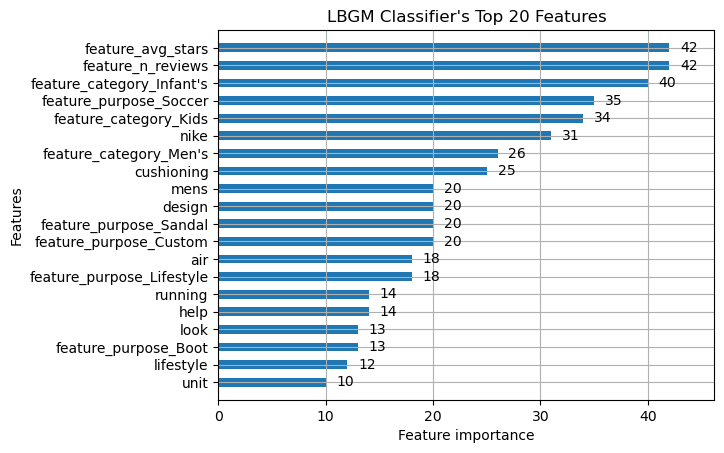

In [80]:
lgb.plot_importance(model, height=.5, max_num_features = 20,
                   title = "LBGM Classifier's Top 20 Features")

## XGBoost Regression Trees

In [81]:
df_model_reg = df_model.copy()
df_model_reg['target_price'] = nike['price']
df_model_reg = df_model_reg.rename(columns = {'target_price': 'price'})
df_model_reg.isna().sum()

price                         0
feature_num_colors           28
feature_n_reviews            28
feature_avg_stars            28
feature_category_Infant's    28
                             ..
zone                          0
zoned                         0
zones                         0
zoom                          0
zoomx                         0
Length: 4850, dtype: int64

In [82]:
df_model_reg.head()

,price,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_category_Infant's,feature_category_Kids,feature_category_Men's,feature_category_Women's,feature_purpose_Basketball,feature_purpose_Boot,...,zion,zions,zip,zipper,zonal,zone,zoned,zones,zoom,zoomx
0,125.0,2.0,2161.0,4.9,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,105.0,3.0,519.0,4.8,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,110.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,110.0,2.0,128.0,4.9,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,200.0,1.0,333.0,4.9,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094763,0.0


In [143]:
reg = LinearRegression()

lin_df = df_model_reg.dropna()

X = lin_df.drop('price', axis=1)
Y = lin_df['price'].values


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .25, random_state = 2)

result = reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)

# print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
# print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred))
print('R2 score:', r2_score(y_pred,y_test))

Mean Squared Error: 4.0963831105697326e+18
Root Mean Squared Error: 2023952348.8881185
R2 score: -0.00019555317085417911


In [83]:
X = df_model_reg.drop('price', axis=1)
Y = df_model_reg['price'].values

X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.15)

In [84]:
model = XGBRegressor()

model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [85]:
score = model.score(X_train, y_train)  
print("Training score: ", score)

scores = cross_val_score(model, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Training score:  0.9521923547627709
Mean cross-validation score: 0.32


In [86]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 1904.68
RMSE: 43.64


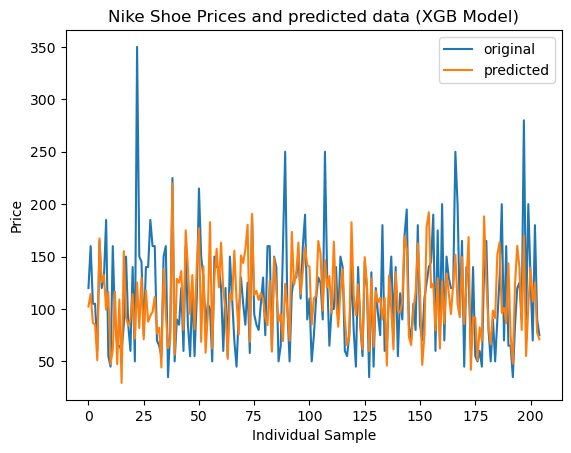

In [87]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Nike Shoe Prices and predicted data (XGB Model)")
plt.xlabel("Individual Sample")
plt.ylabel("Price")
plt.legend()
plt.show()

In [88]:
# f_importance = model.get_booster().get_score(importance_type='gain')

# sorted_f={k: v for k, v in sorted(f_importance.items(), key=lambda item: item[1],reverse=True)}

# importance_df_sort = pd.DataFrame.from_dict(data=sorted_f, orient='index')

# ax = importance_df_sort[0:20].plot.barh()
# ax.invert_yaxis()

In [89]:
# X_train.columns

# len(model.feature_importances_)

#  model.feature_importances_[sorted_idx][-20:]

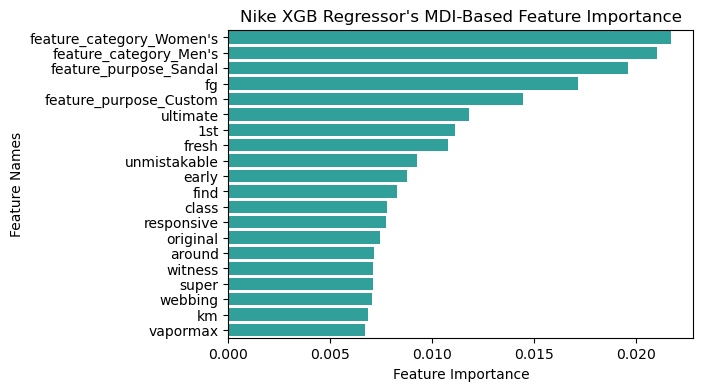

In [90]:
importances = model.feature_importances_
plot_feature_importance(importances, list(X_train.columns), 
                        "Nike XGB Regressor's MDI-Based ", 
                        selected_top = 20)

In [91]:
# sorted_idx = model.feature_importances_.argsort()

# plt.barh(X_train.columns[sorted_idx][-20:], model.feature_importances_[sorted_idx][-20:])
# plt.title("XGBoost Regressor Feature Importance")
# plt.xlabel("Feature Importance")
# plt.ylabel("Feature Names")

In [92]:
# Takes Very long

# perm_importance = permutation_importance(model, X_test, y_test)
# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


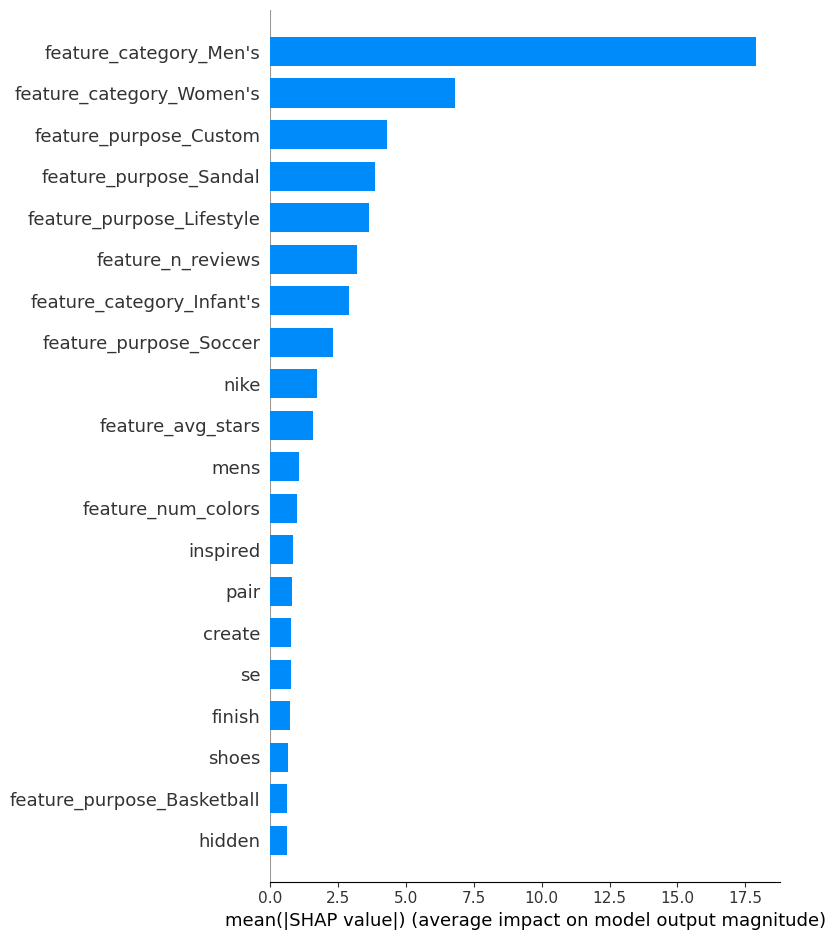

In [93]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type = "bar")

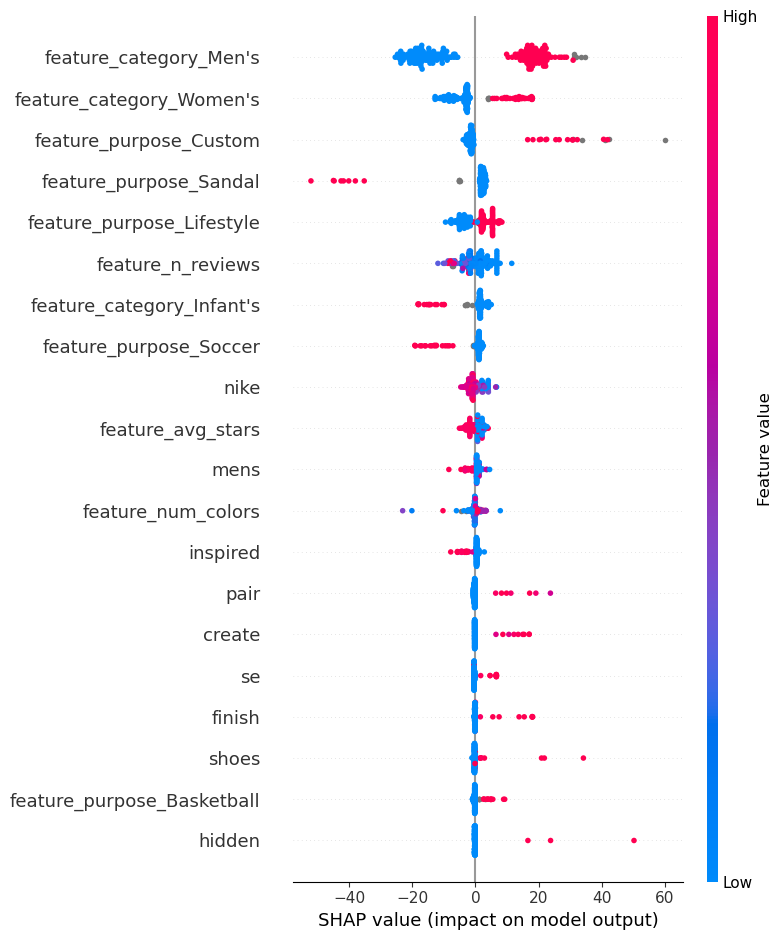

In [94]:
shap.summary_plot(shap_values, X_test)

## LGBM Regression

In [95]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference = lgb_train)
model = lgb.train(params,
                 train_set = lgb_train,
                 valid_sets = lgb_eval,
                 early_stopping_rounds = 30)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Unknown parameter: learning_rage
[1]	valid_0's l1: 38.9215	valid_0's l2: 2434.07
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l1: 37.5561	valid_0's l2: 2310.33
[3]	valid_0's l1: 36.3702	valid_0's l2: 2212.21
[4]	valid_0's l1: 35.3586	valid_0's l2: 2132.58
[5]	valid_0's l1: 34.5704	valid_0's l2: 2069.41
[6]	valid_0's l1: 33.9644	valid_0's l2: 2019.75
[7]	valid_0's l1: 33.2203	valid_0's l2: 1959.96
[8]	valid_0's l1: 32.6773	valid_0's l2: 1913.62
[9]	valid_0's l1: 32.1746	valid_0's l2: 1875.73
[10]	valid_0's l1: 31.687	valid_0's l2: 1844.88
[11]	valid_0's l1: 31.3157	valid_0's l2: 1818.76
[12]	valid_0's l1: 31.1098	valid_0's l2: 1807.63
[13]	valid_0's l1: 30.743	valid_0's l2: 1778.09
[14]	valid_0's l1: 30.5401	valid_0's l2: 1759.33
[15]	valid_0's l1: 30.4959	valid_0's l2: 1752.64
[16]	valid_0's l1: 30.2345	valid_0's l2: 1738.44
[17]	valid_0's l1: 30.1566	valid_0's l2: 1730.59
[18]	valid_0's l1: 30.0641	valid_0's l2: 1722.04
[19]	valid_0's

In [96]:
# prediction
y_pred = model.predict(X_test)

# accuracy check
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

MSE: 1712.14
RMSE: 41.38


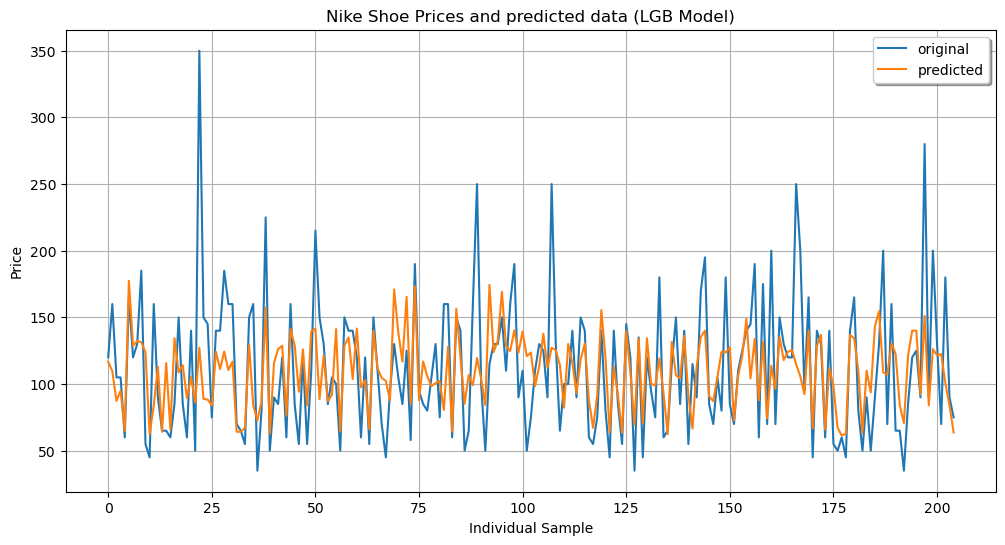

In [97]:
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label = "original")
plt.plot(x_ax, y_pred, label = "predicted")
plt.title("Nike Shoe Prices and predicted data (LGB Model)")
plt.xlabel('Individual Sample')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

<AxesSubplot:title={'center':"Nike LBGM Regressor's Top 20 Features"}, xlabel='Feature importance', ylabel='Features'>

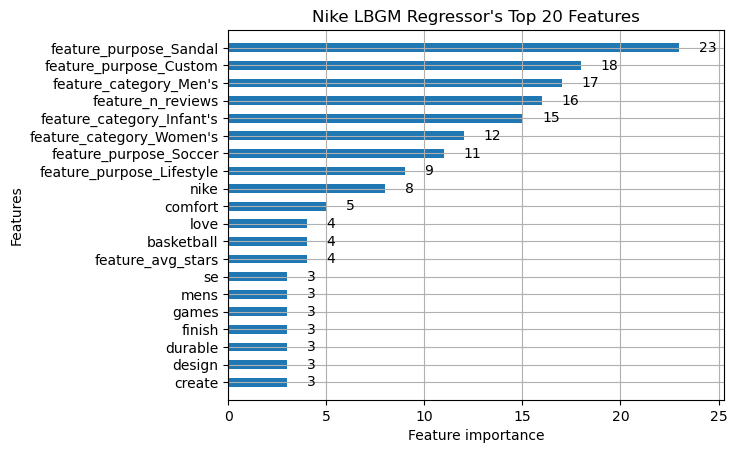

In [98]:
lgb.plot_importance(model, height = .5,
                    max_num_features = 20, 
                    title = "Nike LBGM Regressor's Top 20 Features")

In [108]:
# params = {"booster":"gblinear","objective":"reg:squarederror"}

# xg_reg= XGBRegressor(objective='reg:squarederror', seed=123)

# train_m = xgb.DMatrix(data=X_train, label = y_train)
# test_m = xgb.DMatrix(data=X_test, label = y_test)

# xg_reg= xgb.train(params=params,dtrain=train_m,num_boost_round=5)

# preds = xg_reg.predict(test_m)

# rmse = np.sqrt(mean_squared_error(y_test,preds))
# print("RMSE: %f" % (rmse))

# test_m


# xg_reg.feature_importances_